<a href="https://colab.research.google.com/github/palakagl/NepalEarthquake/blob/main/Richter_Prediction_Nepal_Earthquake_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
#pip install xgboost
#pip install lightgbm
#pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import optuna
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate,KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from confusion_matrix import make_confusion_matrix

pd.set_option('display.max_columns', 70)

ImportError: cannot import name 'make_confusion_matrix' from 'confusion_matrix' (C:\Users\palak\anaconda3\lib\site-packages\confusion_matrix\__init__.py)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Load Data

In [ ]:
# Load Training data target labels
#train_labels_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/train_labels.csv")
# Load Training data
#train_data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/train_values.csv")

# Load testing data
#test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/test_values.csv")
test_data = pd.read_csv("test_values.csv")
train_data_df =pd.read_csv("train_values.csv")

In [ ]:
#Print training data sample
test_data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Add training labels to training dataset
#train_data_df['damage_grade']=train_labels_df['damage_grade']

### 2. Exploratory Data Analysis

In [ ]:
train_data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,260601.0,525675.482773,304544.999032,4.0,261190.0,525757.0,789762.0,1052934.0
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
has_superstructure_adobe_mud,260601.0,0.088645,0.284231,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,260601.0,0.761935,0.425900,0.0,1.0,1.0,1.0,1.0


In [ ]:
dtypes=pd.DataFrame(train_data_df.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=train_data_df.nunique()
dtypes["Null Values"]=train_data_df.isnull().sum()
dtypes["% null Values"]=train_data_df.isnull().sum()/len(train_data_df)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
building_id,int64,260601,0,0.000000
geo_level_1_id,int64,31,0,0.000000
geo_level_2_id,int64,1414,0,0.000000
geo_level_3_id,int64,11595,0,0.000000
count_floors_pre_eq,int64,9,0,0.000000
age,int64,42,0,0.000000
area_percentage,int64,84,0,0.000000
height_percentage,int64,27,0,0.000000
land_surface_condition,object,3,0,0.000000
foundation_type,object,5,0,0.000000


In [ ]:
train_data_df.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

In [ ]:
# Get count of each damage_level
plt.figure(figsize=(12,8))

d=sns.countplot(data = train_data_df
            ,x = 'damage_grade')

plt.title('Distribution of Damage Grades')
plt.xlabel('Damage Grades')
plt.ylabel('Building Count')

total_records = len(train_data_df['damage_grade'])*1.
for p in d.patches:
        d.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))

ValueError: Could not interpret input 'damage_grade'

<Figure size 864x576 with 0 Axes>

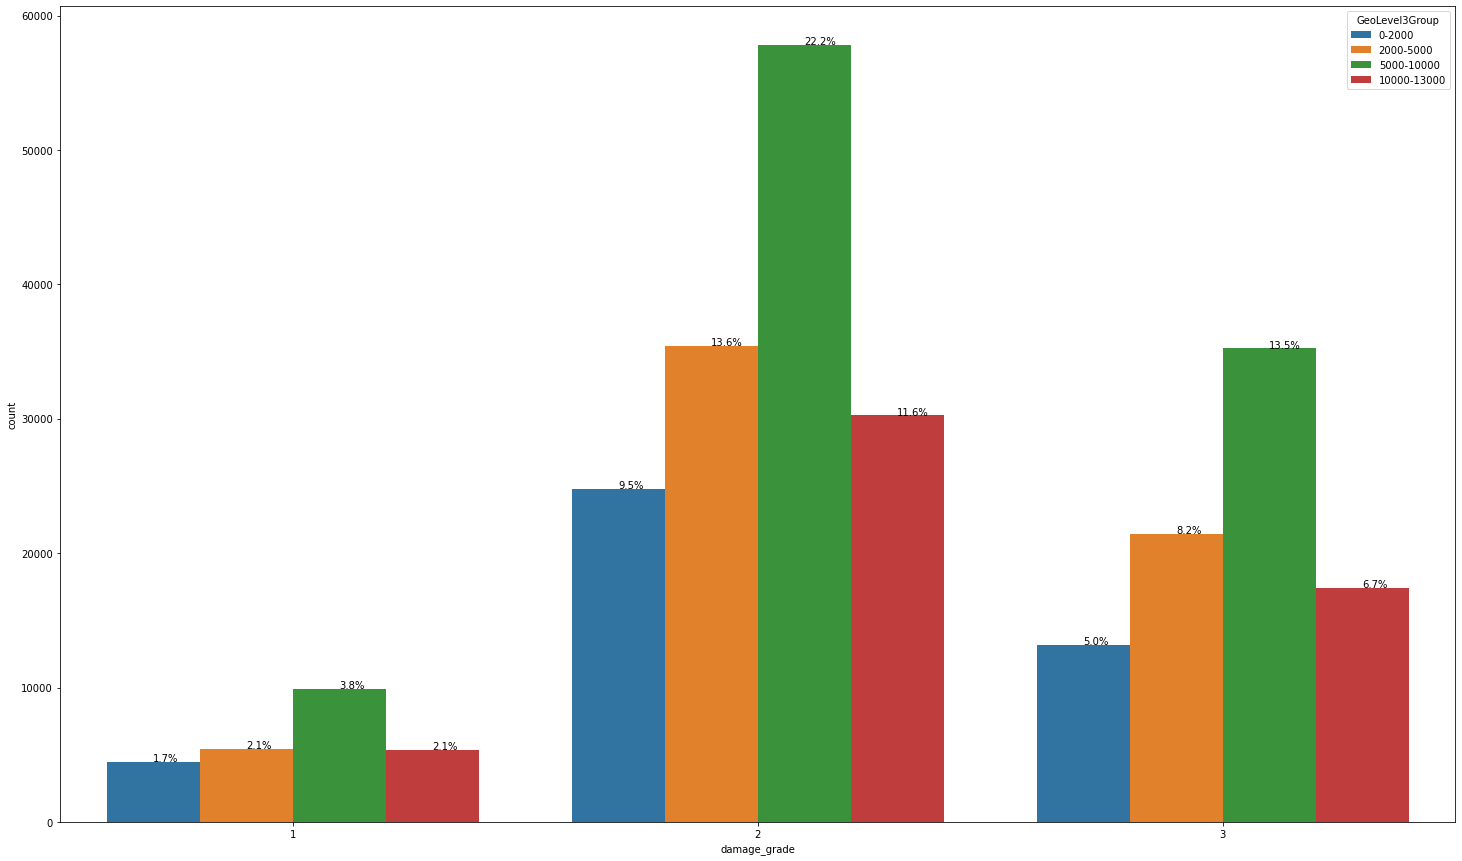

In [ ]:
# Checking train data labels distribution with age of the building
train_data_eda = train_data_df.copy()
#train_data_eda.drop('GeoLevel3Group', axis=1,inplace=True)

geo_level_3_category = pd.cut(train_data_eda.geo_level_3_id,bins=[-1,2000,5000,10000,13000],labels=['0-2000','2000-5000','5000-10000','10000-13000'])

train_data_eda.insert(6,'GeoLevel3Group',geo_level_3_category)

plt.figure(figsize=(25,15))

geo_level_3_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="GeoLevel3Group")
for p in geo_level_3_count.patches:
        geo_level_3_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

**Note - Above graph clearly shows unbalanced data, where samples for damage grade '2' are way over other two. Reason could be missing data, or may be actual data is like that only.

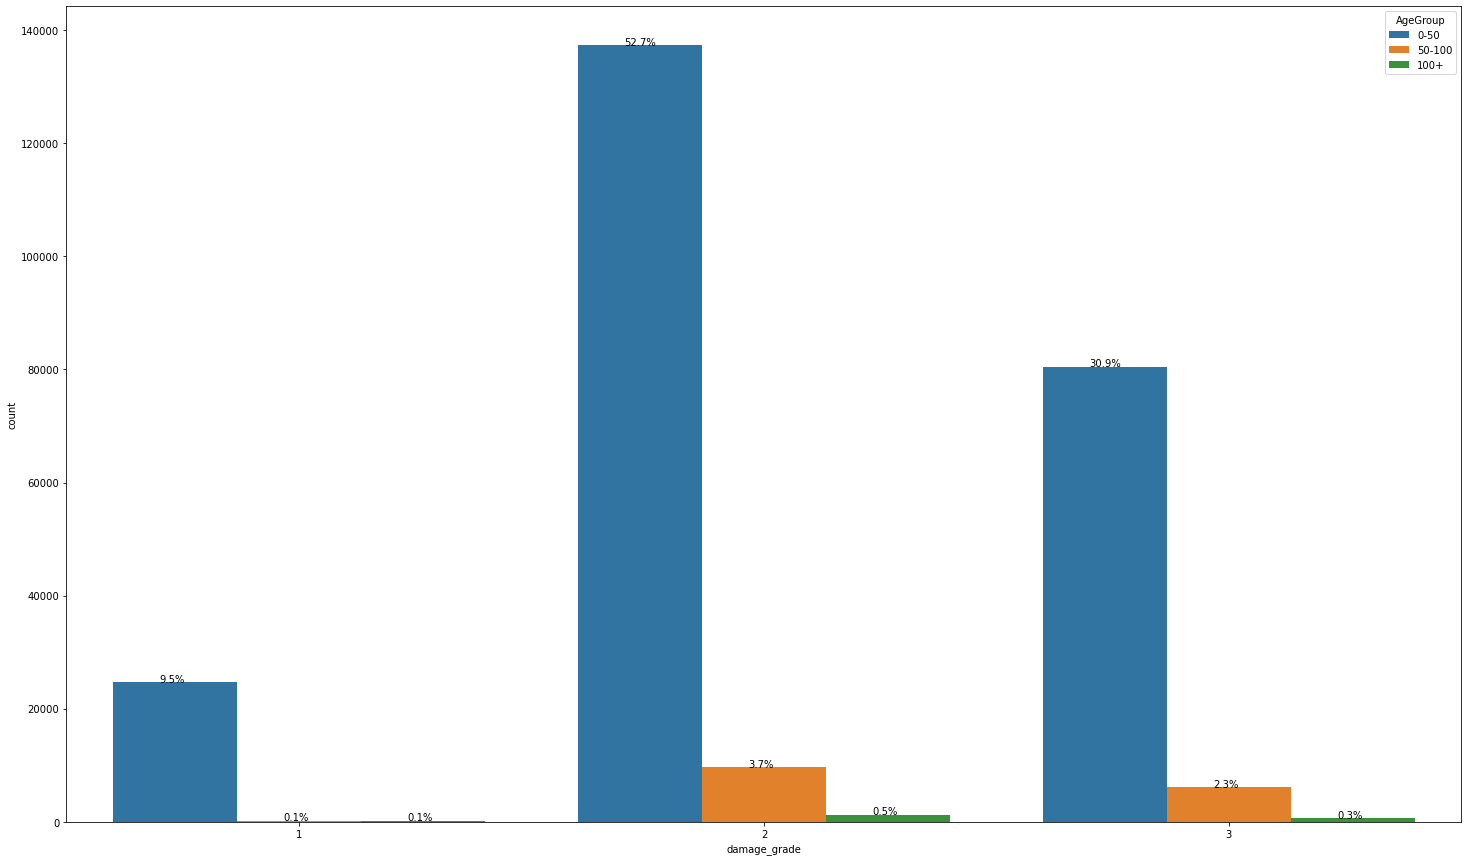

In [ ]:
# Checking train data labels distribution with age of the building

#train_data_eda.drop('AgeGroup', axis=1)

age_category = pd.cut(train_data_eda.age,bins=[-1,50,100,1000],labels=['0-50','50-100','100+'])

train_data_eda.insert(5,'AgeGroup',age_category)

age_category.value_counts()

plt.figure(figsize=(25,15))

age_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="AgeGroup")
for p in age_count.patches:
        age_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

** Note** -
Above graph clearly shows unbalanced data where we have far more data for damage grade '2', compare to other two. 
Also, most of the damaged buildings were of age under 50 years. This could be either data was not collected properly for older buildings, or most of the buildings are not too old.

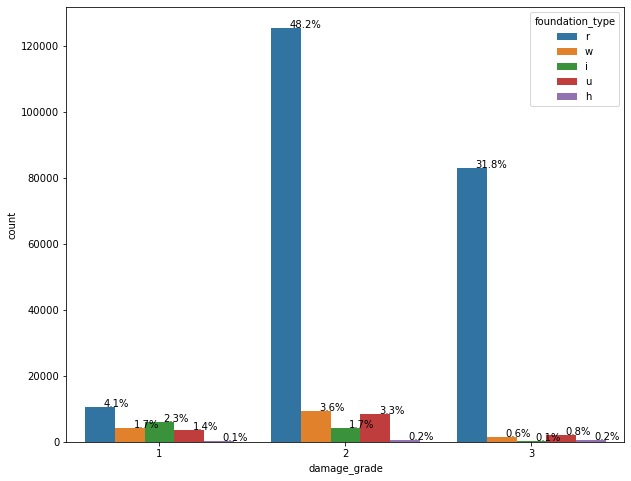

In [ ]:
plt.figure(figsize=(10,8))
foundation_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="foundation_type")
for p in foundation_count.patches:
        foundation_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

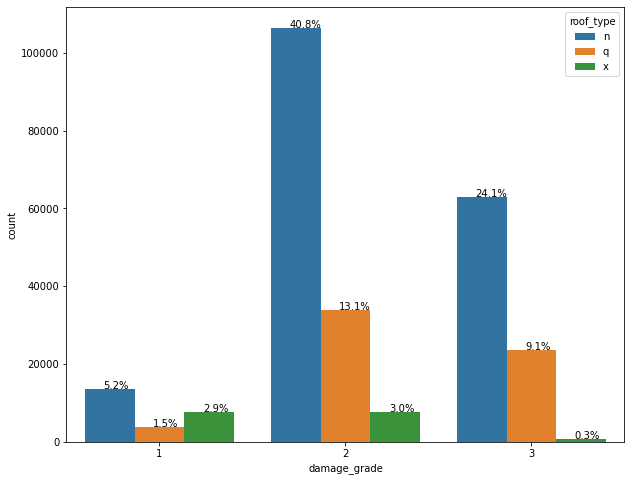

In [ ]:
plt.figure(figsize=(10,8))
roof_type_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="roof_type")
for p in roof_type_count.patches:
        roof_type_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

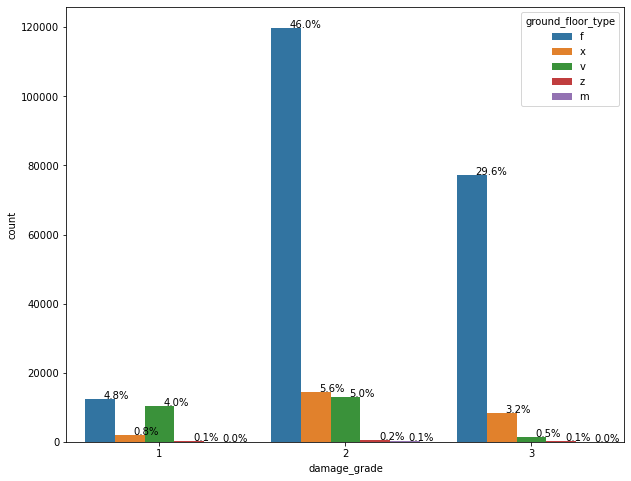

In [ ]:
plt.figure(figsize=(10,8))
ground_floor_type_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="ground_floor_type")
for p in ground_floor_type_count.patches:
        ground_floor_type_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

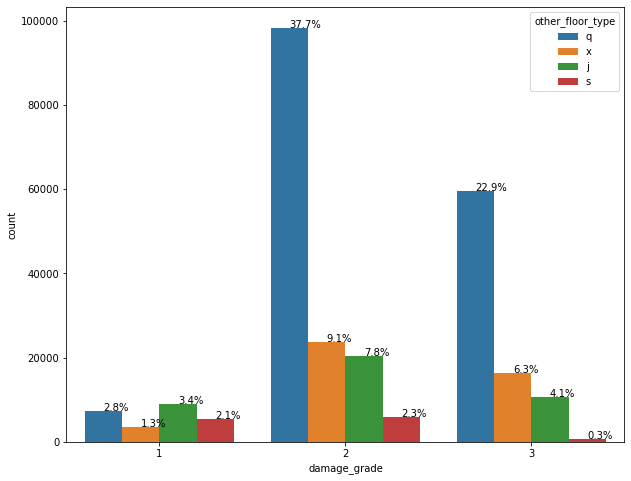

In [ ]:
plt.figure(figsize=(10,8))
other_floor_type_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="other_floor_type")
for p in other_floor_type_count.patches:
        other_floor_type_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

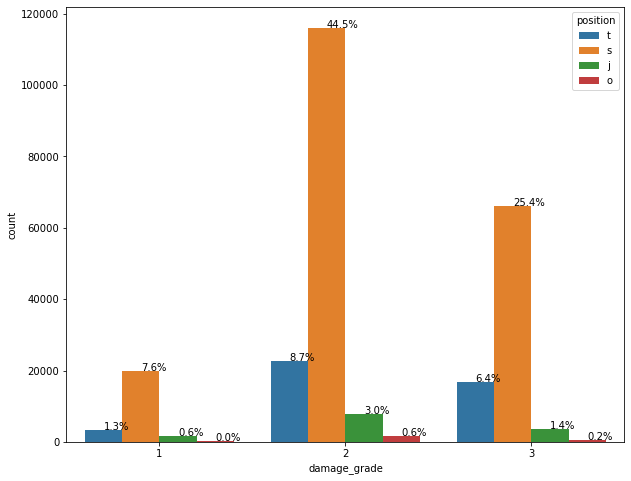

In [ ]:
plt.figure(figsize=(10,8))
position_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="position")
for p in position_count.patches:
        position_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

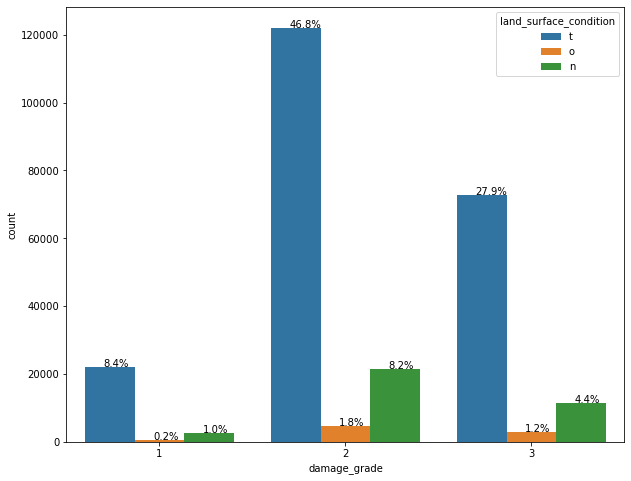

In [ ]:
plt.figure(figsize=(10,8))
land_surface_condition_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="land_surface_condition")
for p in land_surface_condition_count.patches:
        land_surface_condition_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

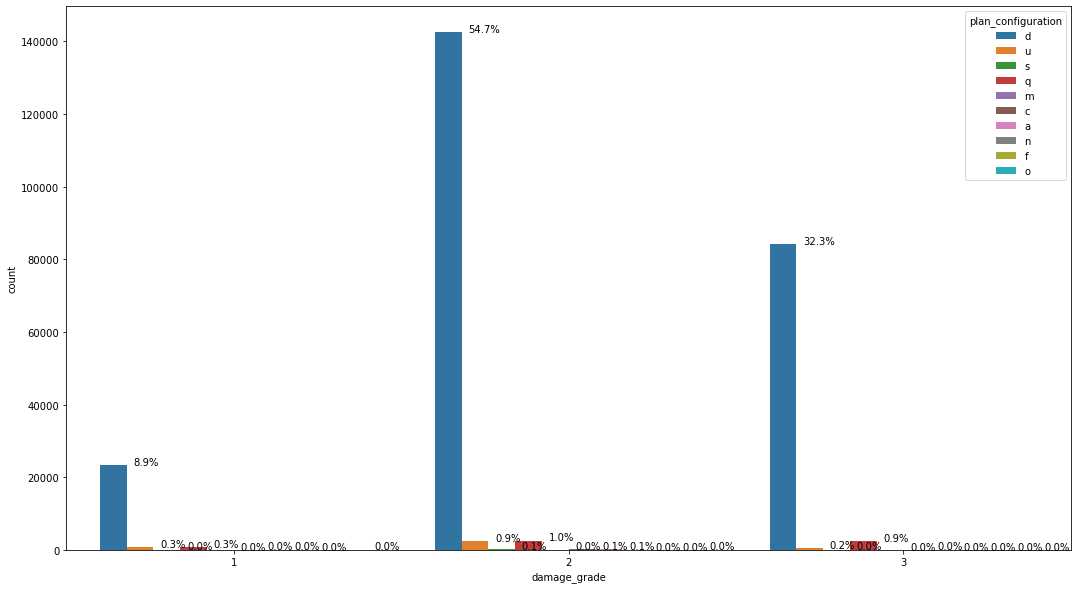

In [ ]:
# Checking train data labels distribution with age of the building
plt.figure(figsize=(18,10))
plan_configuration_count=sns.countplot(data=train_data_eda, hue="plan_configuration", x="damage_grade")
for p in plan_configuration_count.patches:
        plan_configuration_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

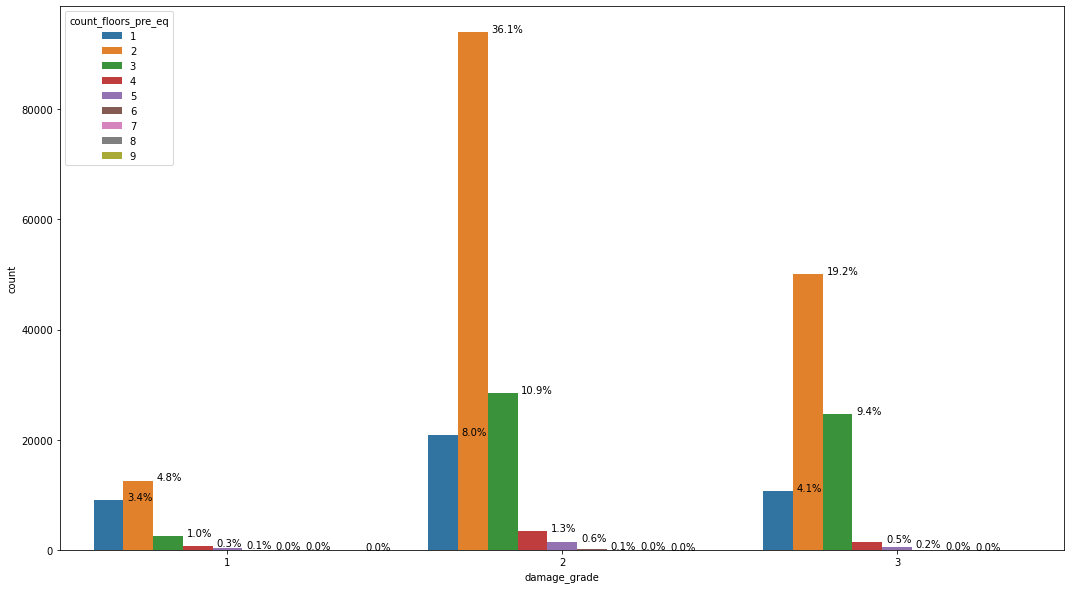

In [ ]:
# Checking train data labels distribution with age of the building
plt.figure(figsize=(18,10))
floor_count=sns.countplot(data=train_data_eda, hue="count_floors_pre_eq", x="damage_grade")
for p in floor_count.patches:
        floor_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

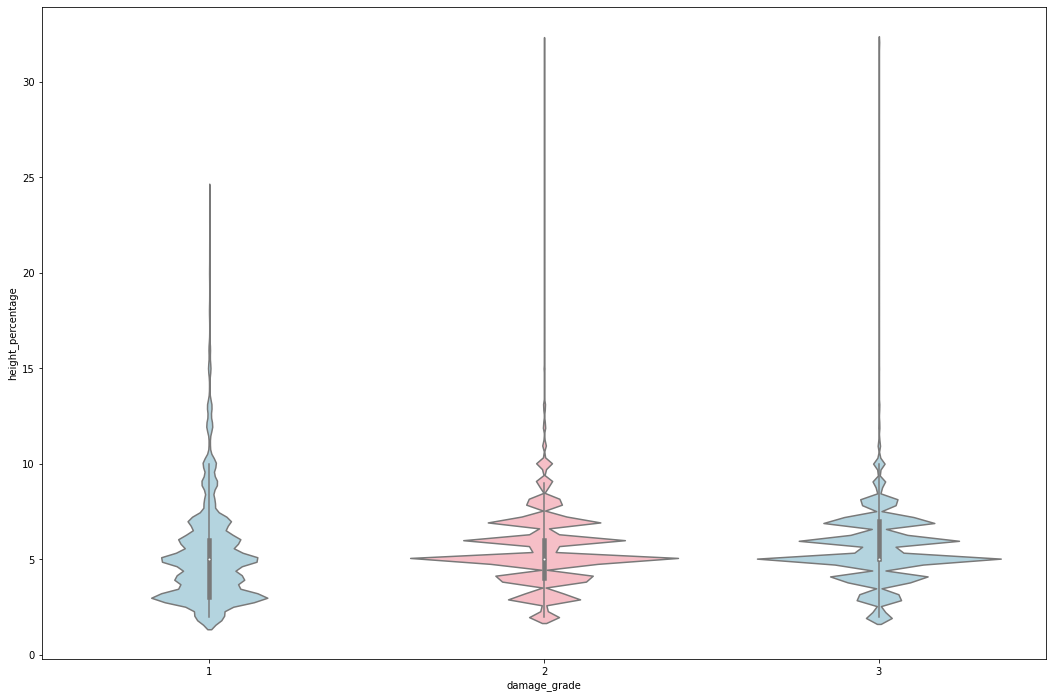

In [ ]:
# Checking height percentage distribution across 3 grades
plt.figure(figsize=(18,12))

sns.violinplot("damage_grade", "height_percentage", data=train_data_eda, palette=["lightblue", "lightpink"]);
plt.show()

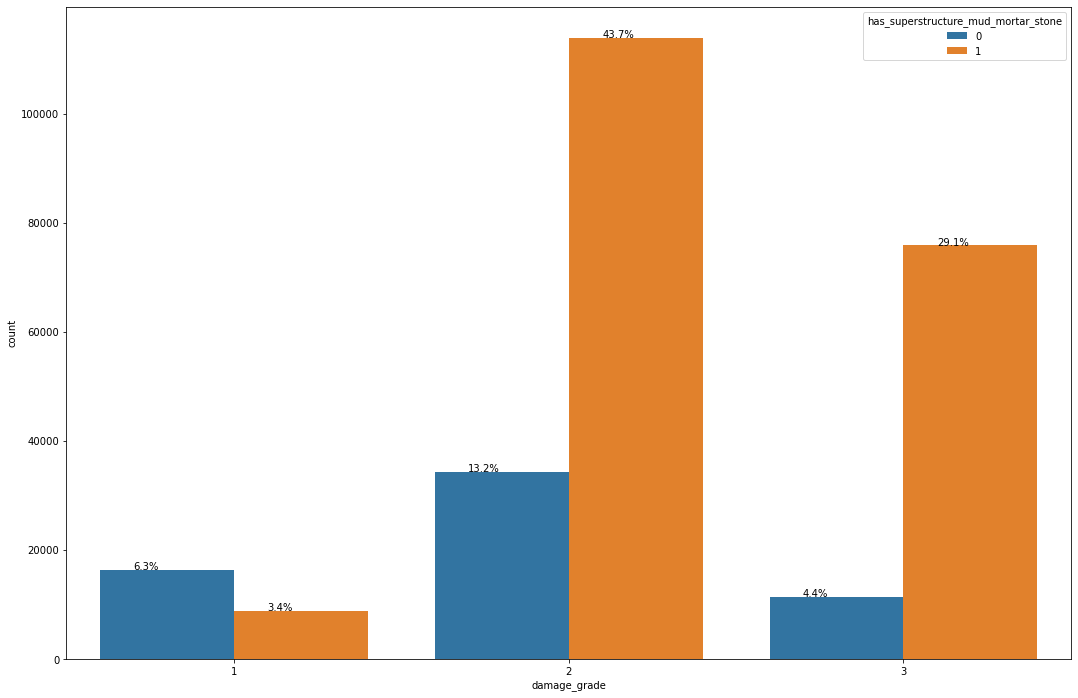

In [ ]:
plt.figure(figsize=(18,12))

mud_mortar_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="has_superstructure_mud_mortar_stone")
for p in mud_mortar_count.patches:
        mud_mortar_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

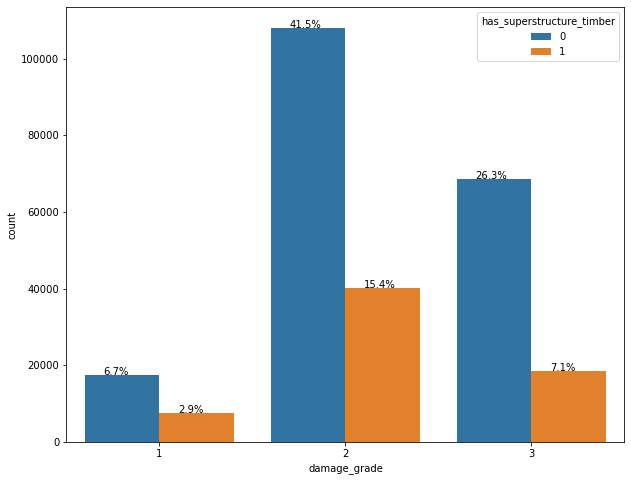

In [ ]:
plt.figure(figsize=(10,8))

has_superstructure_timber_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="has_superstructure_timber")
for p in has_superstructure_timber_count.patches:
        has_superstructure_timber_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

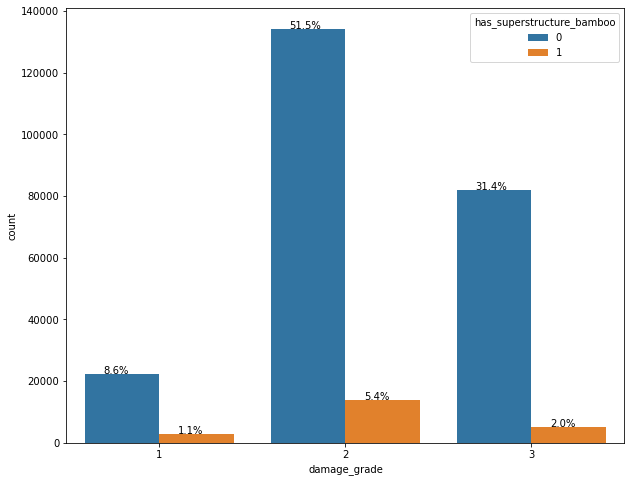

In [ ]:
plt.figure(figsize=(10,8))

has_superstructure_bamboo_count=sns.countplot(data=train_data_eda, x="damage_grade", hue="has_superstructure_bamboo")
for p in has_superstructure_bamboo_count.patches:
        has_superstructure_bamboo_count.annotate('{:.1f}%'.format(100*p.get_height()/total_records), (p.get_x()+0.1, p.get_height()+50))
plt.show()

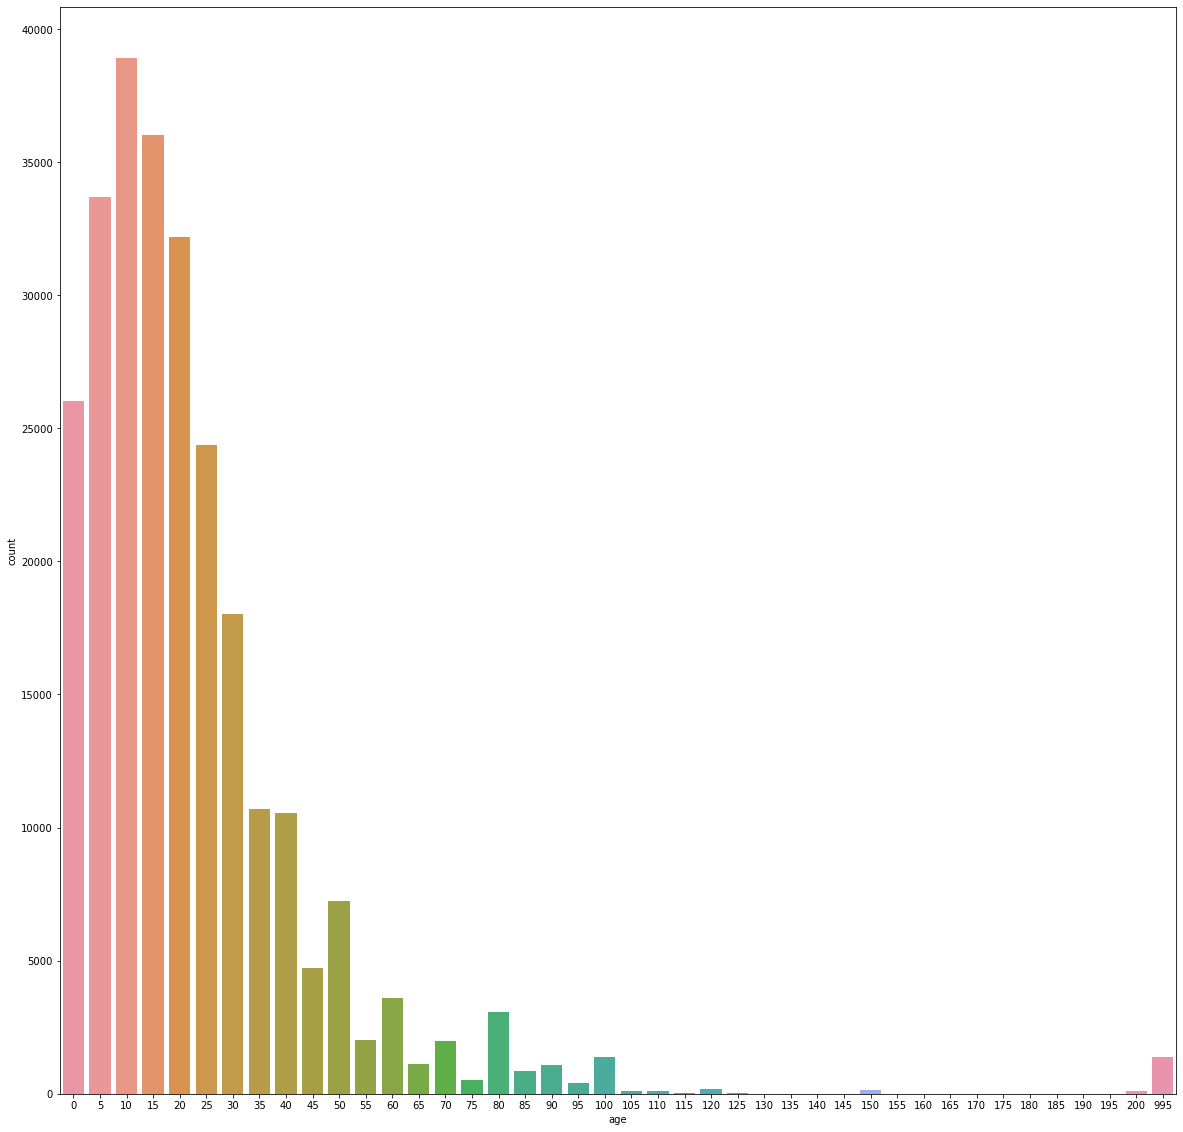

In [ ]:
# plot building age distribution
plt.figure(figsize = (20,20))
sns.countplot(train_data_eda['age'])
plt.show()

### Check Duplicates in data

In [ ]:
##Identify duplicates records in the training data
dupes = train_data_df.duplicated()
print('Train Data Duplicates - ',sum(dupes))
##Identify duplicates records in the test data
dupes = test_data.duplicated()
print('Test Data Duplicates - ',sum(dupes))

Train Data Duplicates -  0
Test Data Duplicates -  0


# Feature Engineering

In [ ]:
# Convert Categorical columns to Numerical

def convertCatgtoNumCols(df):

  df.land_surface_condition = df.land_surface_condition.map({'t':14, 'o':10, 'n':9})
  df.foundation_type = df.foundation_type.map({'r':12, 'w':17, 'i':6, 'u':15, 'h':5})
  df.roof_type = df.roof_type.map({'n':9, 'q':11, 'x':18})
  df.ground_floor_type = df.ground_floor_type.map({'f':4, 'x':18, 'v':16, 'z':19, 'm':8})
  df.other_floor_type = df.other_floor_type.map({'q':11, 'x':18, 'j':7, 's':13})
  df.position = df.position.map({'t':14, 's':13, 'j':7, 'o':10})
  df.plan_configuration = df.plan_configuration.map({'d':3, 'u':15, 's':13, 'q':11, 'm':8, 'c':2, 'a':1, 'n':9, 'f':4, 'o':10})
  df.legal_ownership_status = df.legal_ownership_status.map({'v':16, 'a':1, 'r':12, 'w':17})
  
  return df

# Convert Columns
train_data_df = convertCatgtoNumCols(train_data_df)
test_data = convertCatgtoNumCols(test_data)

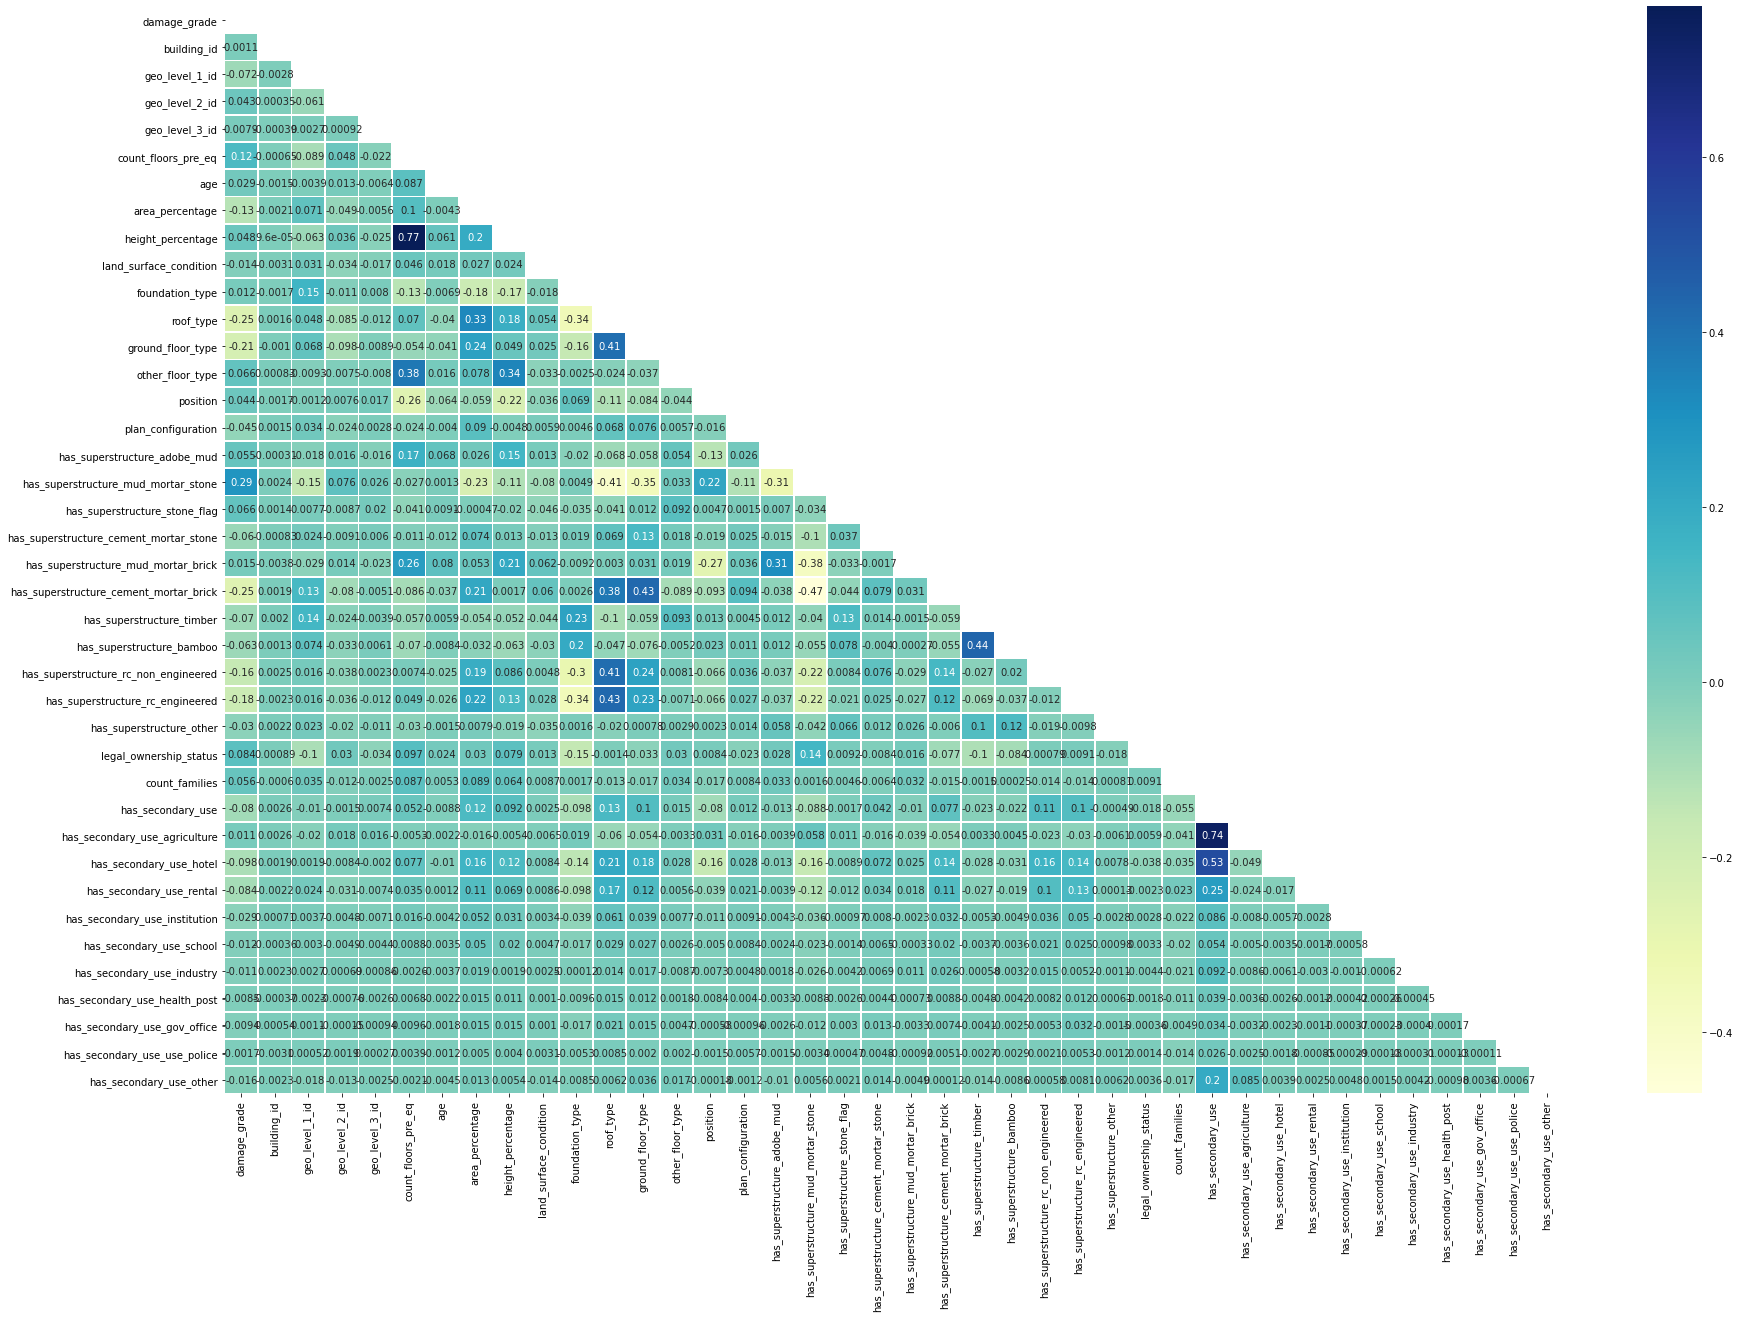

In [ ]:
#Plot Heatmap for better visualization
plt.figure(figsize=(30,20))
corr= train_data_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, annot=True, cmap="YlGnBu", linewidths=.8)  # plot the correlation coefficients as a heatmap
plt.show()

** Note - From above heatmap we can see that following high correlation:
1. Has_secondary_use - Has_secondary_use_agriculture
2. Has_secondary_use - Has_secondary_use_hotel
As we don't get additional information from highly correlated features, we can remove one of them.

In [ ]:
corr_target_row = corr["damage_grade"].sort_values(ascending = True)
print(corr_target_row.head())

has_superstructure_cement_mortar_brick   -0.254131
roof_type                                -0.245984
ground_floor_type                        -0.214498
has_superstructure_rc_engineered         -0.179014
has_superstructure_rc_non_engineered     -0.158145
Name: damage_grade, dtype: float64


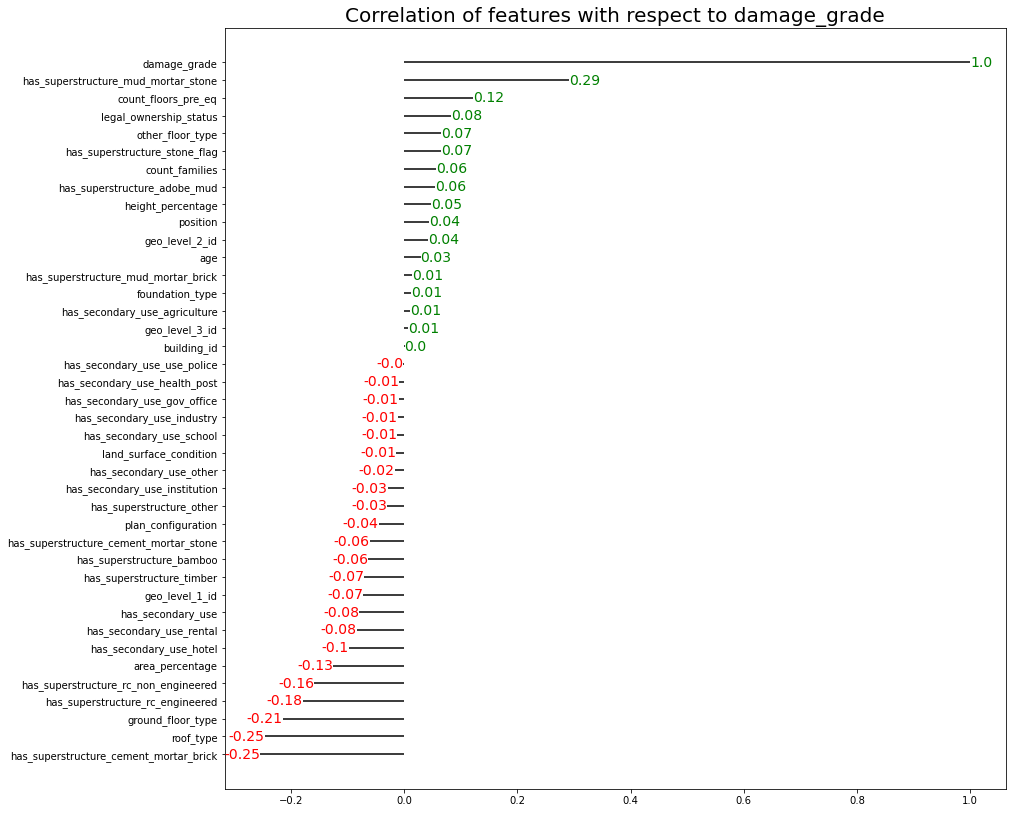

In [ ]:
# See the results better in a graph

plt.figure(figsize = (14, 14))
plt.hlines(y = corr_target_row.index, xmin = 0, xmax = corr_target_row.values)

for x, y, tex in zip(corr_target_row.values, corr_target_row.index, corr_target_row.values):
    t = plt.text(x, y, round(tex, 2), horizontalalignment = 'right' if x < 0 else 'left', 
    verticalalignment = 'center', fontdict = {'color':'red' if x < 0 else 'green', 'size':14})

plt.title('Correlation of features with respect to damage_grade', fontdict = {'size':20})
plt.savefig('cofwrtdg.png', bbox_inches = 'tight')

In [ ]:
def pre_process(train_data, test_data, fillna_dict = {}, drop_list = []):
    test_train_data = pd.concat([train_data, test_data], ignore_index=True, axis=0)
        
    # Step 1: Fill missing values
    for col, fill_value in fillna_dict.items():
        test_train_data[col] = test_train_data[col].fillna(value=fill_value)
        
     # Step 2: Add features    
    test_train_data['building_volume_percentage'] = test_train_data['area_percentage'] * test_train_data['height_percentage']
       
    # Step 3: Drop columns
    test_train_data.drop(columns=drop_list, inplace=True, errors='ignore')
    
    test_train_data = pd.get_dummies(test_train_data).reset_index(drop=True)
    
    new_train_data = test_train_data.iloc[:len(train_data), :]
    new_test_data = test_train_data.iloc[len(train_data):, :]
    X_train = new_train_data.drop('damage_grade', axis=1)
    y_train = pd.DataFrame(new_train_data['damage_grade'].values.ravel()).astype(int)
    X_test = new_test_data.drop('damage_grade', axis=1)
    return X_train, y_train, X_test
    

In [ ]:
fillna_dict = {}
drop_list = ['building_id','has_secondary_use_agriculture','has_secondary_use_hotel','height_percentage','area_percentage']

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

X, y, X_test = pre_process(train_data_df.copy(),
                          test_data.copy(),
                           fillna_dict=fillna_dict,
                           drop_list=drop_list
                          )

print(X.shape)
print(X_test.shape)
X

(260601, 40)
(86868, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,building_volume_percentage
0,802906,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,1,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,30
1,28830,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,56
2,94947,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,25
3,590882,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,0,1,0,0,0,0,1,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,30
4,201944,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,1,0,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,9,12,9,4,7,13,11,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,18
260597,669485,17,715,2060,2,0,6,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,30
260598,602512,17,51,8163,3,55,6,7,14,12,11,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,42
260599,151409,26,39,1851,2,10,14,6,14,12,18,16,13,7,3,0,0,0,0,0,1,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,84


# Model Building

**Let's try following algorithms:**

* Random forest
* XGBoost

In [ ]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

### Random Forest

In [ ]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(random_state = RANDOM_SEED, max_depth = 20, 
                            n_estimators = 50, min_samples_split = 2, 
                            min_samples_leaf = 1)
rf.fit(X, y)

# predict the target on the train dataset
rf_predict_train = rf.predict(X)

# Accuray Score on train dataset
rf_accuracy_train = accuracy_score(y,rf_predict_train)
print('\nRandom Forest-accuracy_score on train dataset : ', rf_accuracy_train)

<ipython-input-200-4af0ed643a4d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)



Random Forest-accuracy_score on train dataset :  0.8042639897774759


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [rf_accuracy_train]})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Random Forest,0.804264


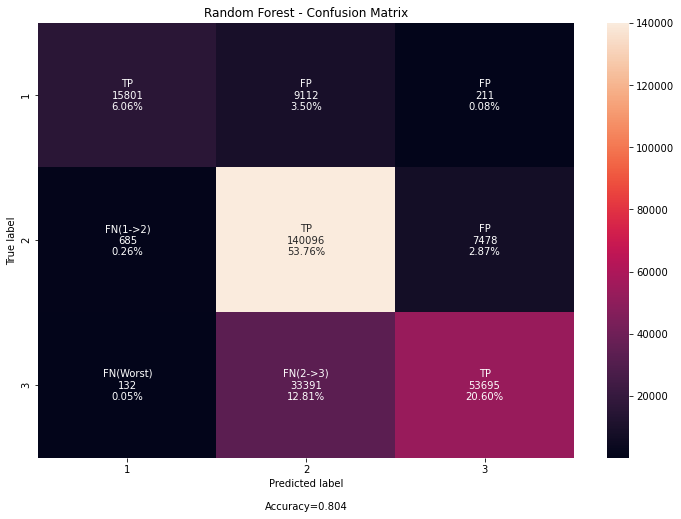

In [ ]:
cm=confusion_matrix(y,rf_predict_train)
categories = ['1', '2','3']
labels = ['TP','FP','FP','FN(1->2)','TP','FP','FN(Worst)','FN(2->3)','TP']

make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      figsize=(12,8), 
                      cbar=True,
                    title='Random Forest - Confusion Matrix',
                     cmap="rocket")

In [ ]:
print("classification report for Random Forest :\n\n",classification_report(y,rf_predict_train))

classification report for Random Forest :

               precision    recall  f1-score   support

           1       0.95      0.63      0.76     25124
           2       0.77      0.94      0.85    148259
           3       0.87      0.62      0.72     87218

    accuracy                           0.80    260601
   macro avg       0.86      0.73      0.78    260601
weighted avg       0.82      0.80      0.80    260601



In [ ]:
# Predict for test dataset
prediction=rf.predict(X_test)
rf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
rf_result['building_id']=test_data['building_id']
rf_result.rename(columns={0:'damage_grade'},inplace=True)
rf_result=rf_result[['building_id','damage_grade']]

rf_result.to_csv("drivendata_submission_rf.csv",index=False)

### XGBoost

In [ ]:
xgBoost = XGBClassifier()
xgBoost.fit(X, y)

# predict the target on the train dataset
xgBoost_predict_train = xgBoost.predict(X)

# Accuray Score on train dataset
xgBoost_accuracy_train = accuracy_score(y,xgBoost_predict_train)
print('\nXGBoost-accuracy_score on train dataset : ', xgBoost_accuracy_train)

G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[01:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost-accuracy_score on train dataset :  0.7450009785073733


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'accuracy': [xgBoost_accuracy_train]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Random Forest,0.804264
0,XGBoost,0.745001


In [ ]:
# Predict for test dataset
prediction=xgBoost.predict(X_test)
xgBoost_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgBoost_result['building_id']=test_data['building_id']
xgBoost_result.rename(columns={0:'damage_grade'},inplace=True)
xgBoost_result=xgBoost_result[['building_id','damage_grade']]

xgBoost_result.to_csv("drivendata_submission_xgBoost.csv",index=False)

# HyperParameter Tuning

### Hypertuning - XGBoost - RandomizedSearchCV

In [ ]:
# Param grid for Xgboost

n_jobs=[-1]
n_estimators=np.arange(100,1000,100)
learning_rate=[0.03,0.01,0.1]
max_depth=np.arange(10,100,15)

param_grid={'n_jobs':n_jobs,
            'n_estimators':n_estimators,
            'max_depth':max_depth,
            'learning_rate':learning_rate
           }

xgBoost_tune = XGBClassifier()

#rs=RandomizedSearchCV(xgBoost_tune,param_distributions=param_grid,cv=kfolds,scoring='f1_micro')

#rs.fit(X,y)

#rs.best_params_

In [ ]:
xgboost_rs_cv_clf=XGBClassifier(n_jobs=-1,
                                n_estimators=500, 
                                max_depth=10,
                                learning_rate= 0.1,
                                colsample_bytree=0.5)
xgboost_rs_cv_clf.fit(X,y)

# predict the target on the train dataset
xgBoost_hypertune_predict_train = xgboost_rs_cv_clf.predict(X)

# Predict for test dataset
prediction=xgboost_rs_cv_clf.predict(X_test)
xgBoost_rs_cv_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgBoost_rs_cv_clf_result['building_id']=test_data['building_id']
xgBoost_rs_cv_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgBoost_rs_cv_clf_result=xgBoost_rs_cv_clf_result[['building_id','damage_grade']]

xgBoost_rs_cv_clf_result.to_csv("drivendata_submission_xgBoost_random_search_cv.csv",index=False)

G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[01:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


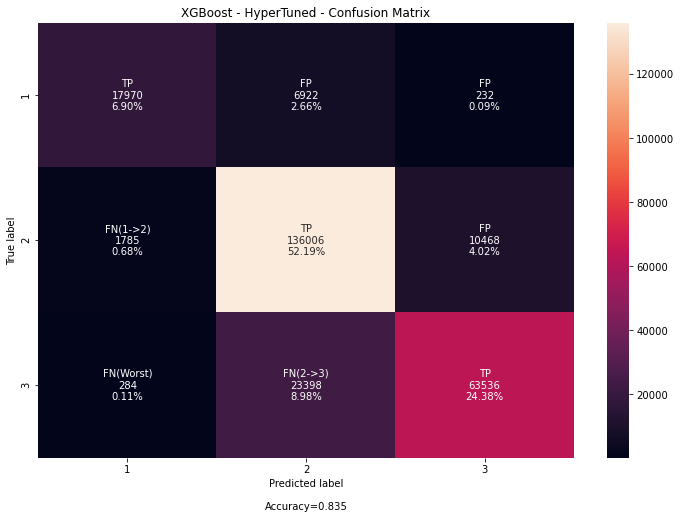

In [ ]:
cm_xgboost=confusion_matrix(y,xgBoost_hypertune_predict_train)
categories = ['1', '2','3']
labels = ['TP','FP','FP','FN(1->2)','TP','FP','FN(Worst)','FN(2->3)','TP']

make_confusion_matrix(cm_xgboost, 
                      group_names=labels,
                      categories=categories,
                      figsize=(12,8), 
                      cbar=True,
                    title='XGBoost - HyperTuned - Confusion Matrix',
                     cmap="rocket")

In [ ]:
# Accuray Score on train dataset
xgBoost_hypertune_accuracy_train = accuracy_score(y,xgBoost_hypertune_predict_train)
print('\nXGBoost- With Hyperparameter Tuning accuracy_score on train dataset : ', xgBoost_hypertune_accuracy_train)

#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost-With Hyperparameter Tuning'], 'accuracy': [xgBoost_hypertune_accuracy_train]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf


XGBoost- With Hyperparameter Tuning accuracy_score on train dataset :  0.8346552776082977


,Method,accuracy
0,Random Forest,0.804264
0,XGBoost,0.745001
0,XGBoost-With Hyperparameter Tuning,0.834655


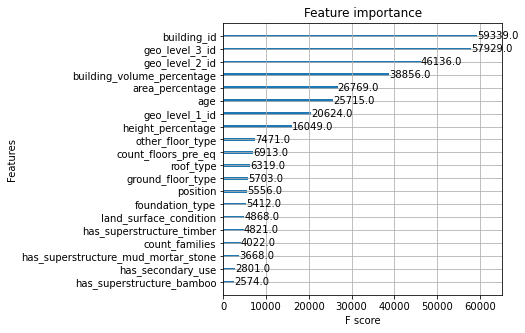

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(xgboost_rs_cv_clf, max_num_features=20, ax=ax)

In [ ]:
print("classification report for XGBoost With Hyperparameter Tuning :\n\n",classification_report(y,xgBoost_hypertune_predict_train))

classification report for XGBoost With Hyperparameter Tuning :

               precision    recall  f1-score   support

           1       0.90      0.72      0.80     25124
           2       0.82      0.92      0.86    148259
           3       0.86      0.73      0.79     87218

    accuracy                           0.83    260601
   macro avg       0.86      0.79      0.82    260601
weighted avg       0.84      0.83      0.83    260601



In [ ]:
#Print training data sample
test_data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,14,12,18,16,7,14,3,0,0,0,0,0,1,0,0,0,0,0,16,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0


### Stepwise Hypertuning - XGBoost - Optuna

### Optuna - Maximize Score Metrics

In [ ]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial: Trial,X,y) -> float:

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 1, 10),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 0.25, 1),
                'learning_rate':trial.suggest_uniform('learning_rate',0, 0.1),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,0.5,0.01),
                'subsample':trial.suggest_float('subsample', 0.01, 1),
                'num_boost_round':trial.suggest_float('num_boost_round', 100,1000)
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, X, y, cv=kfolds).mean()

In [ ]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,y),n_trials= 10)


[I 2021-12-01 02:58:48,039] A new study created in memory with name: no-name-961b0275-dcd7-4af0-b299-03bf0a4e9aee
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  war

[02:58:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 03:36:23,190] Trial 0 finished with value: 0.6860641349654802 and parameters: {'n_estimators': 565, 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.09737882751847095, 'colsample_bytree': 0.33, 'subsample': 0.6714901263658057, 'num_boost_round': 321.46385726695974}. Best is trial 0 with value: 0.6860641349654802.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is depr

[03:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:36:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 05:54:30,003] Trial 1 finished with value: 0.7227102014598668 and parameters: {'n_estimators': 963, 'max_depth': 8, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.016177163713021237, 'colsample_bytree': 0.29000000000000004, 'subsample': 0.20429889119145284, 'num_boost_round': 891.3822569347732}. Best is trial 1 with value: 0.7227102014598668.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBCl

[05:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:54:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:58:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 06:30:17,422] Trial 2 finished with value: 0.6891493119498874 and parameters: {'n_estimators': 642, 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.09781589740598806, 'colsample_bytree': 0.1, 'subsample': 0.860710342870218, 'num_boost_round': 157.50810975675702}. Best is trial 1 with value: 0.7227102014598668.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprec

[06:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 09:17:32,944] Trial 3 finished with value: 0.7457300706003445 and parameters: {'n_estimators': 656, 'max_depth': 9, 'reg_alpha': 5, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.0670973464914371, 'colsample_bytree': 0.47, 'subsample': 0.7869733332833408, 'num_boost_round': 458.22748258637404}. Best is trial 3 with value: 0.7457300706003445.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is depre

[09:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 12:11:18,867] Trial 4 finished with value: 0.7303617503099391 and parameters: {'n_estimators': 873, 'max_depth': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.02022115267829505, 'colsample_bytree': 0.44000000000000006, 'subsample': 0.25537598384015814, 'num_boost_round': 166.12212248437316}. Best is trial 3 with value: 0.7457300706003445.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBCl

[12:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[I 2021-12-01 14:43:37,393] Trial 5 finished with value: 0.7365743052864077 and parameters: {'n_estimators': 912, 'max_depth': 6, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.06583720693236587, 'colsample_bytree': 0.39, 'subsample': 0.473997903445895, 'num_boost_round': 921.5868838155058}. Best is trial 3 with value: 0.7457300706003445.
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].
  warnings.warn(
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprec

[14:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:43:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

xgb_optuna_score_clf_best_params=study.best_trial.params

Best trial: score 0.7457300706003445,
params {'n_estimators': 656, 'max_depth': 9, 'reg_alpha': 5, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.0670973464914371, 'colsample_bytree': 0.47, 'subsample': 0.7869733332833408, 'num_boost_round': 458.22748258637404}


In [ ]:
xgb_optuna_score_clf = XGBClassifier(**xgb_optuna_score_clf_best_params, random_state=RANDOM_SEED, n_jobs=-1)
xgb_optuna_score_clf.fit(X, y);

# Predict for test dataset
prediction=xgb_optuna_score_clf.predict(X_test)
xgb_optuna_score_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgb_optuna_score_clf_result['building_id']=test_data['building_id']
xgb_optuna_score_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgb_optuna_score_clf_result=xgb_optuna_score_clf_result[['building_id','damage_grade']]

xgb_optuna_score_clf_result.to_csv("drivendata_submission_xgBoost_optuna_score.csv",index=False)

[14:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Optuna - Maximize F1 Micro Score

In [ ]:
import xgboost as xgb
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback

In [ ]:
score_func = metrics.f1_score
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params


def objective(trial, X, y, group, score, params=dict()):
    dtrain = xgb.DMatrix(X, label=y)
    class_weight = (y.shape[0] - np.sum(y)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgb.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]


def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial,X, y,group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params

In [ ]:

#xgb_optuna_f1_score_clf_best_params = stepwise_optimization()

#xgb_optuna_f1_score_clf = XGBClassifier(**xgb_optuna_f1_score_clf_best_params, random_state=RANDOM_SEED, n_jobs=-1)
xgb_optuna_f1_score_clf.fit(X, y);

# Predict for test dataset
prediction=xgb_optuna_f1_score_clf.predict(X_test)
xgb_optuna_f1_score_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgb_optuna_f1_score_clf_result['building_id']=test_data['building_id']
xgb_optuna_f1_score_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgb_optuna_f1_score_clf_result=xgb_optuna_f1_score_clf_result[['building_id','damage_grade']]

xgb_optuna_f1_score_clf_result.to_csv("drivendata_submission_xgBoost_optuna_f1score.csv",index=False)

G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[15:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# predict the target on the train dataset
xgBoost_f1_predict_train = xgb_optuna_f1_score_clf.predict(X)

# Accuray Score on train dataset
xgBoost_f1_accuracy_train = accuracy_score(y,xgBoost_f1_predict_train)
print('\nXGBoost-accuracy_score on train dataset : ', xgBoost_f1_accuracy_train)


XGBoost-accuracy_score on train dataset :  0.7782548800656943
